This notebook performs hyperparameter optimization for neural networks on the MNIST addition task.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model
import random
import optuna
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances, 
    plot_parallel_coordinate, 
    plot_contour, 
    plot_slice
)
import os
import json

from src.data_handler import MNISTAdditionDataset
from src.models import DigitAdditionModel, OptunaOptimizer
from src.visualization import (
    plot_sample_additions,
    plot_training_history,
    plot_confusion_matrix,
    visualize_incorrect_predictions,
)
from src.plot_settings import set_publication_style

# Set plot style for publication quality
set_publication_style()

# Set random seed to ensure reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Create output directories
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('logs', exist_ok=True)

## Load and Validate Data

Data shapes:
Training images: (50000, 28, 56)
Training labels: (50000,)

Value ranges:
Image min: 0.000, max: 1.000
Label min: 0, max: 18


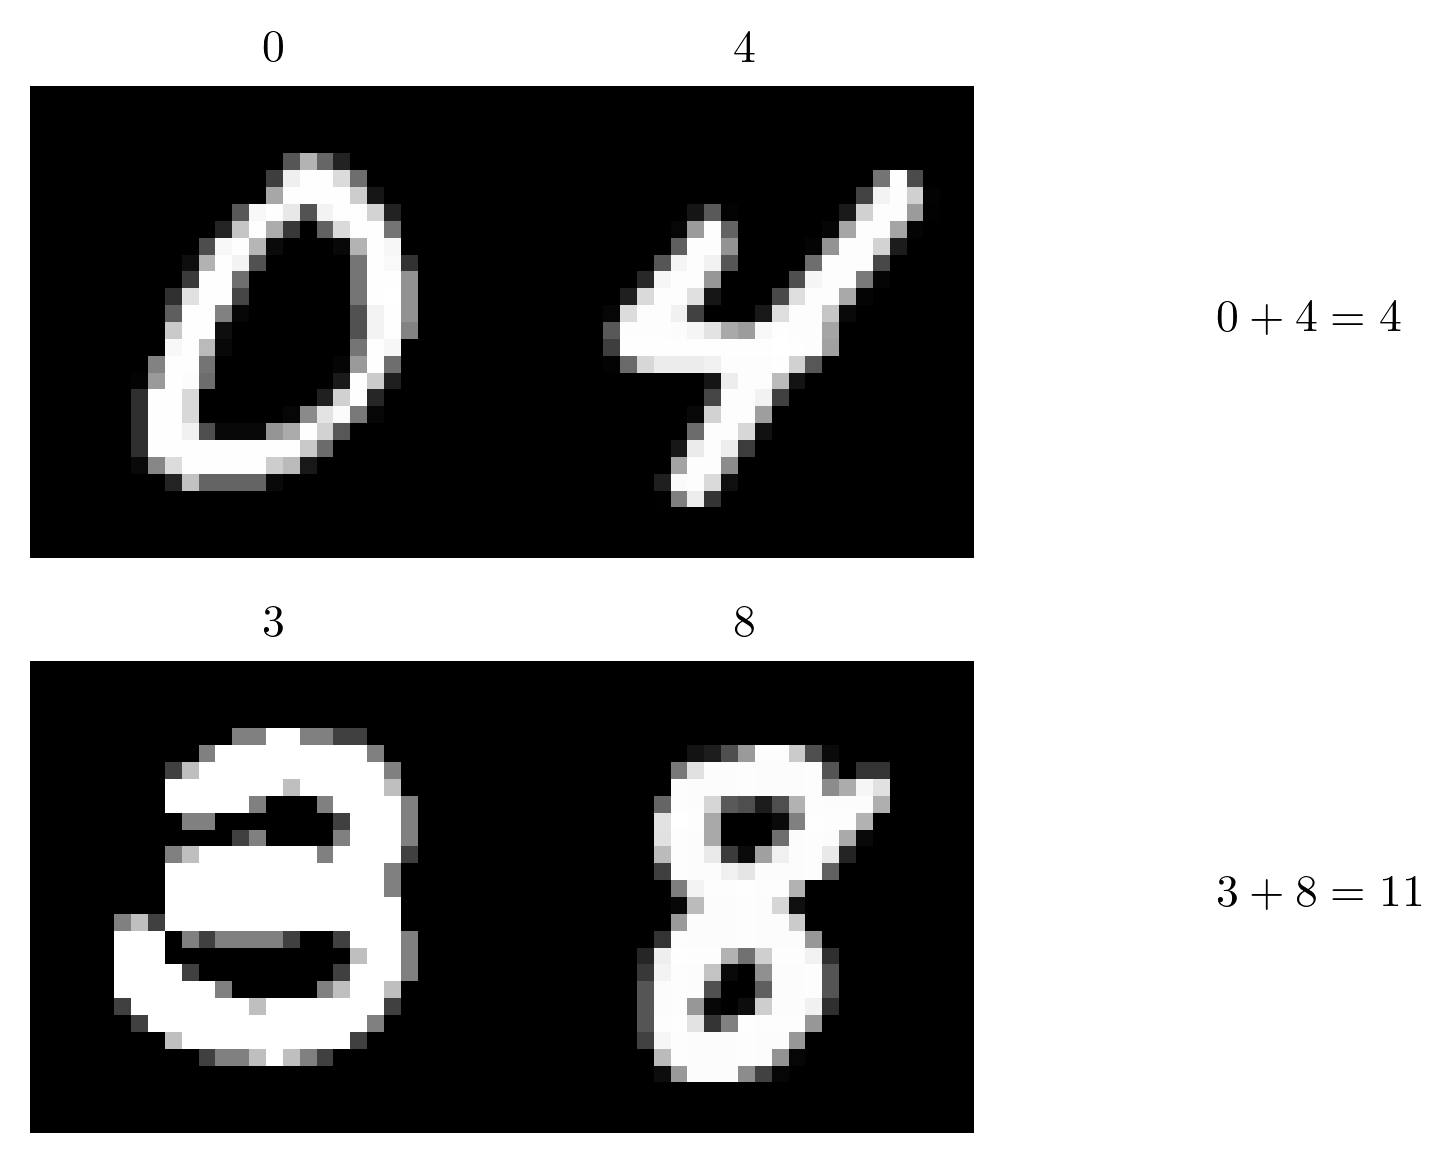

In [2]:
# Create dataset
dataset = MNISTAdditionDataset(seed=seed)
data = dataset.create_datasets()

# Visualize some examples
plot_sample_additions(data['train'][0], data['train'][1], data['train'][2], num_samples=2)

# Print data shapes and ranges
print("Data shapes:")
print(f"Training images: {data['train'][0].shape}")
print(f"Training labels: {data['train'][1].shape}\n")

print("Value ranges:")
print(f"Image min: {data['train'][0].min():.3f}, max: {data['train'][0].max():.3f}")
print(f"Label min: {data['train'][1].min()}, max: {data['train'][1].max()}")

## Hyperparameter Optimization with Optuna

We'll use Optuna to efficiently search for the best hyperparameters. Optuna uses Tree-structured Parzen Estimators (TPE) which is more efficient than grid search.

In [3]:
# Create TensorFlow datasets
train_ds = dataset.get_tf_dataset(data['train'][0], data['train'][1])
val_ds = dataset.get_tf_dataset(data['val'][0], data['val'][1])
test_ds = dataset.get_tf_dataset(data['test'][0], data['test'][1], shuffle=False)

# Define hyperparameter search ranges
param_ranges = {
    'n_layers': (2, 4),             # Search between 2-4 layers
    'units_per_layer': (64, 1024),  # Search between 64-1024 units per layer
    'dropout_rate': (0.1, 0.4),
    'learning_rate': (1e-4, 1e-3),
    'l2_reg': (1e-6, 1e-6),         # Fixed L2 regularization here
    'activation': ['relu', 'elu']
}

# Create optimizer with custom ranges
optimizer = OptunaOptimizer(train_ds, val_ds, param_ranges)

# Run optimization with logging
best_params = optimizer.optimize(
    n_trials=50,
    study_name="mnist_addition_v1",
    log_file='logs/optimization.log'
)

2024-12-11 11:10:45,794 [INFO] Starting hyperparameter optimization
2024-12-11 11:10:45,794 [INFO] Parameter ranges:
2024-12-11 11:10:45,794 [INFO]   n_layers: (2, 4)
2024-12-11 11:10:45,795 [INFO]   units_per_layer: (64, 1024)
2024-12-11 11:10:45,795 [INFO]   dropout_rate: (0.1, 0.4)
2024-12-11 11:10:45,796 [INFO]   learning_rate: (0.0001, 0.001)
2024-12-11 11:10:45,796 [INFO]   l2_reg: (1e-06, 1e-06)
2024-12-11 11:10:45,796 [INFO]   activation: ['relu', 'elu']
[I 2024-12-11 11:10:45,797] A new study created in memory with name: mnist_addition_v1
2024-12-11 11:10:45,798 [INFO] 
Starting 50 trials...
[I 2024-12-11 11:14:29,682] Trial 0 finished with value: 0.9035000205039978 and parameters: {'n_layers': 3, 'dropout_rate': 0.38521429192297485, 'learning_rate': 0.0005395030966670229, 'l2_reg': 1e-06, 'activation': 'relu', 'units_l0': 98, 'units_l1': 75, 'units_l2': 706}. Best is trial 0 with value: 0.9035000205039978.
2024-12-11 11:14:29,682 [INFO] 
Trial 0 finished with value: 0.9035
20

InvalidArgumentError: Graph execution error:

Detected at node adam/truediv_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/gs/q6cb20s96xl8zvw1zgbf79hc0000gn/T/ipykernel_22857/915674827.py", line 20, in <module>

  File "/Users/clementine/mphildis/coursework/M1/xl628/notebooks/../src/models.py", line 323, in optimize

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/optuna/study/study.py", line 475, in optimize

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/optuna/study/_optimize.py", line 63, in _optimize

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/optuna/study/_optimize.py", line 160, in _optimize_sequential

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial

  File "/Users/clementine/mphildis/coursework/M1/xl628/notebooks/../src/models.py", line 249, in objective

  File "/Users/clementine/mphildis/coursework/M1/xl628/notebooks/../src/models.py", line 101, in train

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 73, in train_step

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 344, in apply_gradients

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 409, in apply

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 472, in _backend_apply_gradients

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 122, in _backend_update_step

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 136, in _distributed_tf_update_step

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 133, in apply_grad_to_update_var

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/optimizers/adam.py", line 147, in update_step

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 5876, in divide

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/backend/tensorflow/sparse.py", line 780, in sparse_wrapper

  File "/Users/clementine/anaconda3/envs/dis/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 2316, in divide

Incompatible shapes: [0] vs. [1568,727]
	 [[{{node adam/truediv_1}}]] [Op:__inference_one_step_on_iterator_3574138]

In [14]:
best_params = optimizer.best_trial.params
study = optimizer.study

from optuna.visualization import (
    plot_edf, 
    plot_hypervolume_history, 
    plot_intermediate_values, 
    plot_pareto_front, 
    plot_terminator_improvement, 
    plot_timeline, 
    plot_rank
)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 5,
    "axes.labelsize": 5,
    "axes.titlesize": 5,
    "legend.fontsize": 5,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "figure.titlesize": 5
})
# Create directory for visualization outputs
os.makedirs('results/optuna_plots', exist_ok=True)

# Plot and save optimization visualizations
fig1 = plot_optimization_history(study)
fig1.write_image("results/optuna_plots/optimization_history.pdf")

fig2 = plot_param_importances(study)
fig2.write_image("results/optuna_plots/param_importances.pdf")

fig3 = plot_parallel_coordinate(study)
fig3.write_image("results/optuna_plots/parallel_coordinate.pdf")

fig4 = plot_contour(study)
fig4.write_image("results/optuna_plots/contour.pdf")

fig5 = plot_slice(study)
fig5.write_image("results/optuna_plots/slice.pdf")

fig6 = plot_edf(study)
fig6.write_image("results/optuna_plots/edf.pdf")

fig7 = plot_intermediate_values(study)
fig7.write_image("results/optuna_plots/intermediate_values.pdf")

fig9 = plot_terminator_improvement(study)
fig9.write_image("results/optuna_plots/terminator_improvement.pdf")

fig10 = plot_timeline(study)
fig10.write_image("results/optuna_plots/timeline.pdf")

fig11 = plot_rank(study)
fig11.write_image("results/optuna_plots/rank.pdf")

[W 2024-12-11 14:43:33,859] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,860] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,861] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,861] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,861] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,861] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,862] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,862] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,863] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,863] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,863] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,864] Param l2_reg unique value length is less than 2.
[W 2024-12-11 14:43:33,865] Param l2_reg unique value length is less than 2.

In [5]:
# best_params = optimizer.best_trial.params
# Print optimization results summary
print("\nFinal Results Summary:")
print(optimizer.get_results_summary())

# Display the log file
print("\nOptimization Log:")
with open('logs/optimization.log', 'r') as f:
    print(f.read())


Final Results Summary:
Hyperparameter Optimization Results:
--------------------------------------------------

Best Trial:
  Value (Validation Accuracy): 0.9634
  Hyperparameters:
    n_layers: 4
    dropout_rate: 0.17753778267309397
    learning_rate: 0.00040593004933114283
    l2_reg: 1e-06
    activation: elu
    units_l0: 567
    units_l1: 215
    units_l2: 208
    units_l3: 823

Parameter Importance:
  units_l0: 0.4870
  n_layers: 0.3066
  learning_rate: 0.0712
  dropout_rate: 0.0632
  units_l1: 0.0558
  activation: 0.0162
  l2_reg: 0.0000


Optimization Log:
2024-12-10 18:20:51,734 [INFO] Starting hyperparameter optimization
2024-12-10 18:20:51,736 [INFO] Parameter ranges:
2024-12-10 18:20:51,736 [INFO]   n_layers: (2, 4)
2024-12-10 18:20:51,736 [INFO]   units_per_layer: (64, 512)
2024-12-10 18:20:51,737 [INFO]   dropout_rate: (0.1, 0.4)
2024-12-10 18:20:51,737 [INFO]   learning_rate: (0.0001, 0.001)
2024-12-10 18:20:51,737 [INFO]   l2_reg: (1e-06, 0.0001)
2024-12-10 18:20:51,7

## Train Final Model

Using the best hyperparameters found by Optuna, we'll train the final model.

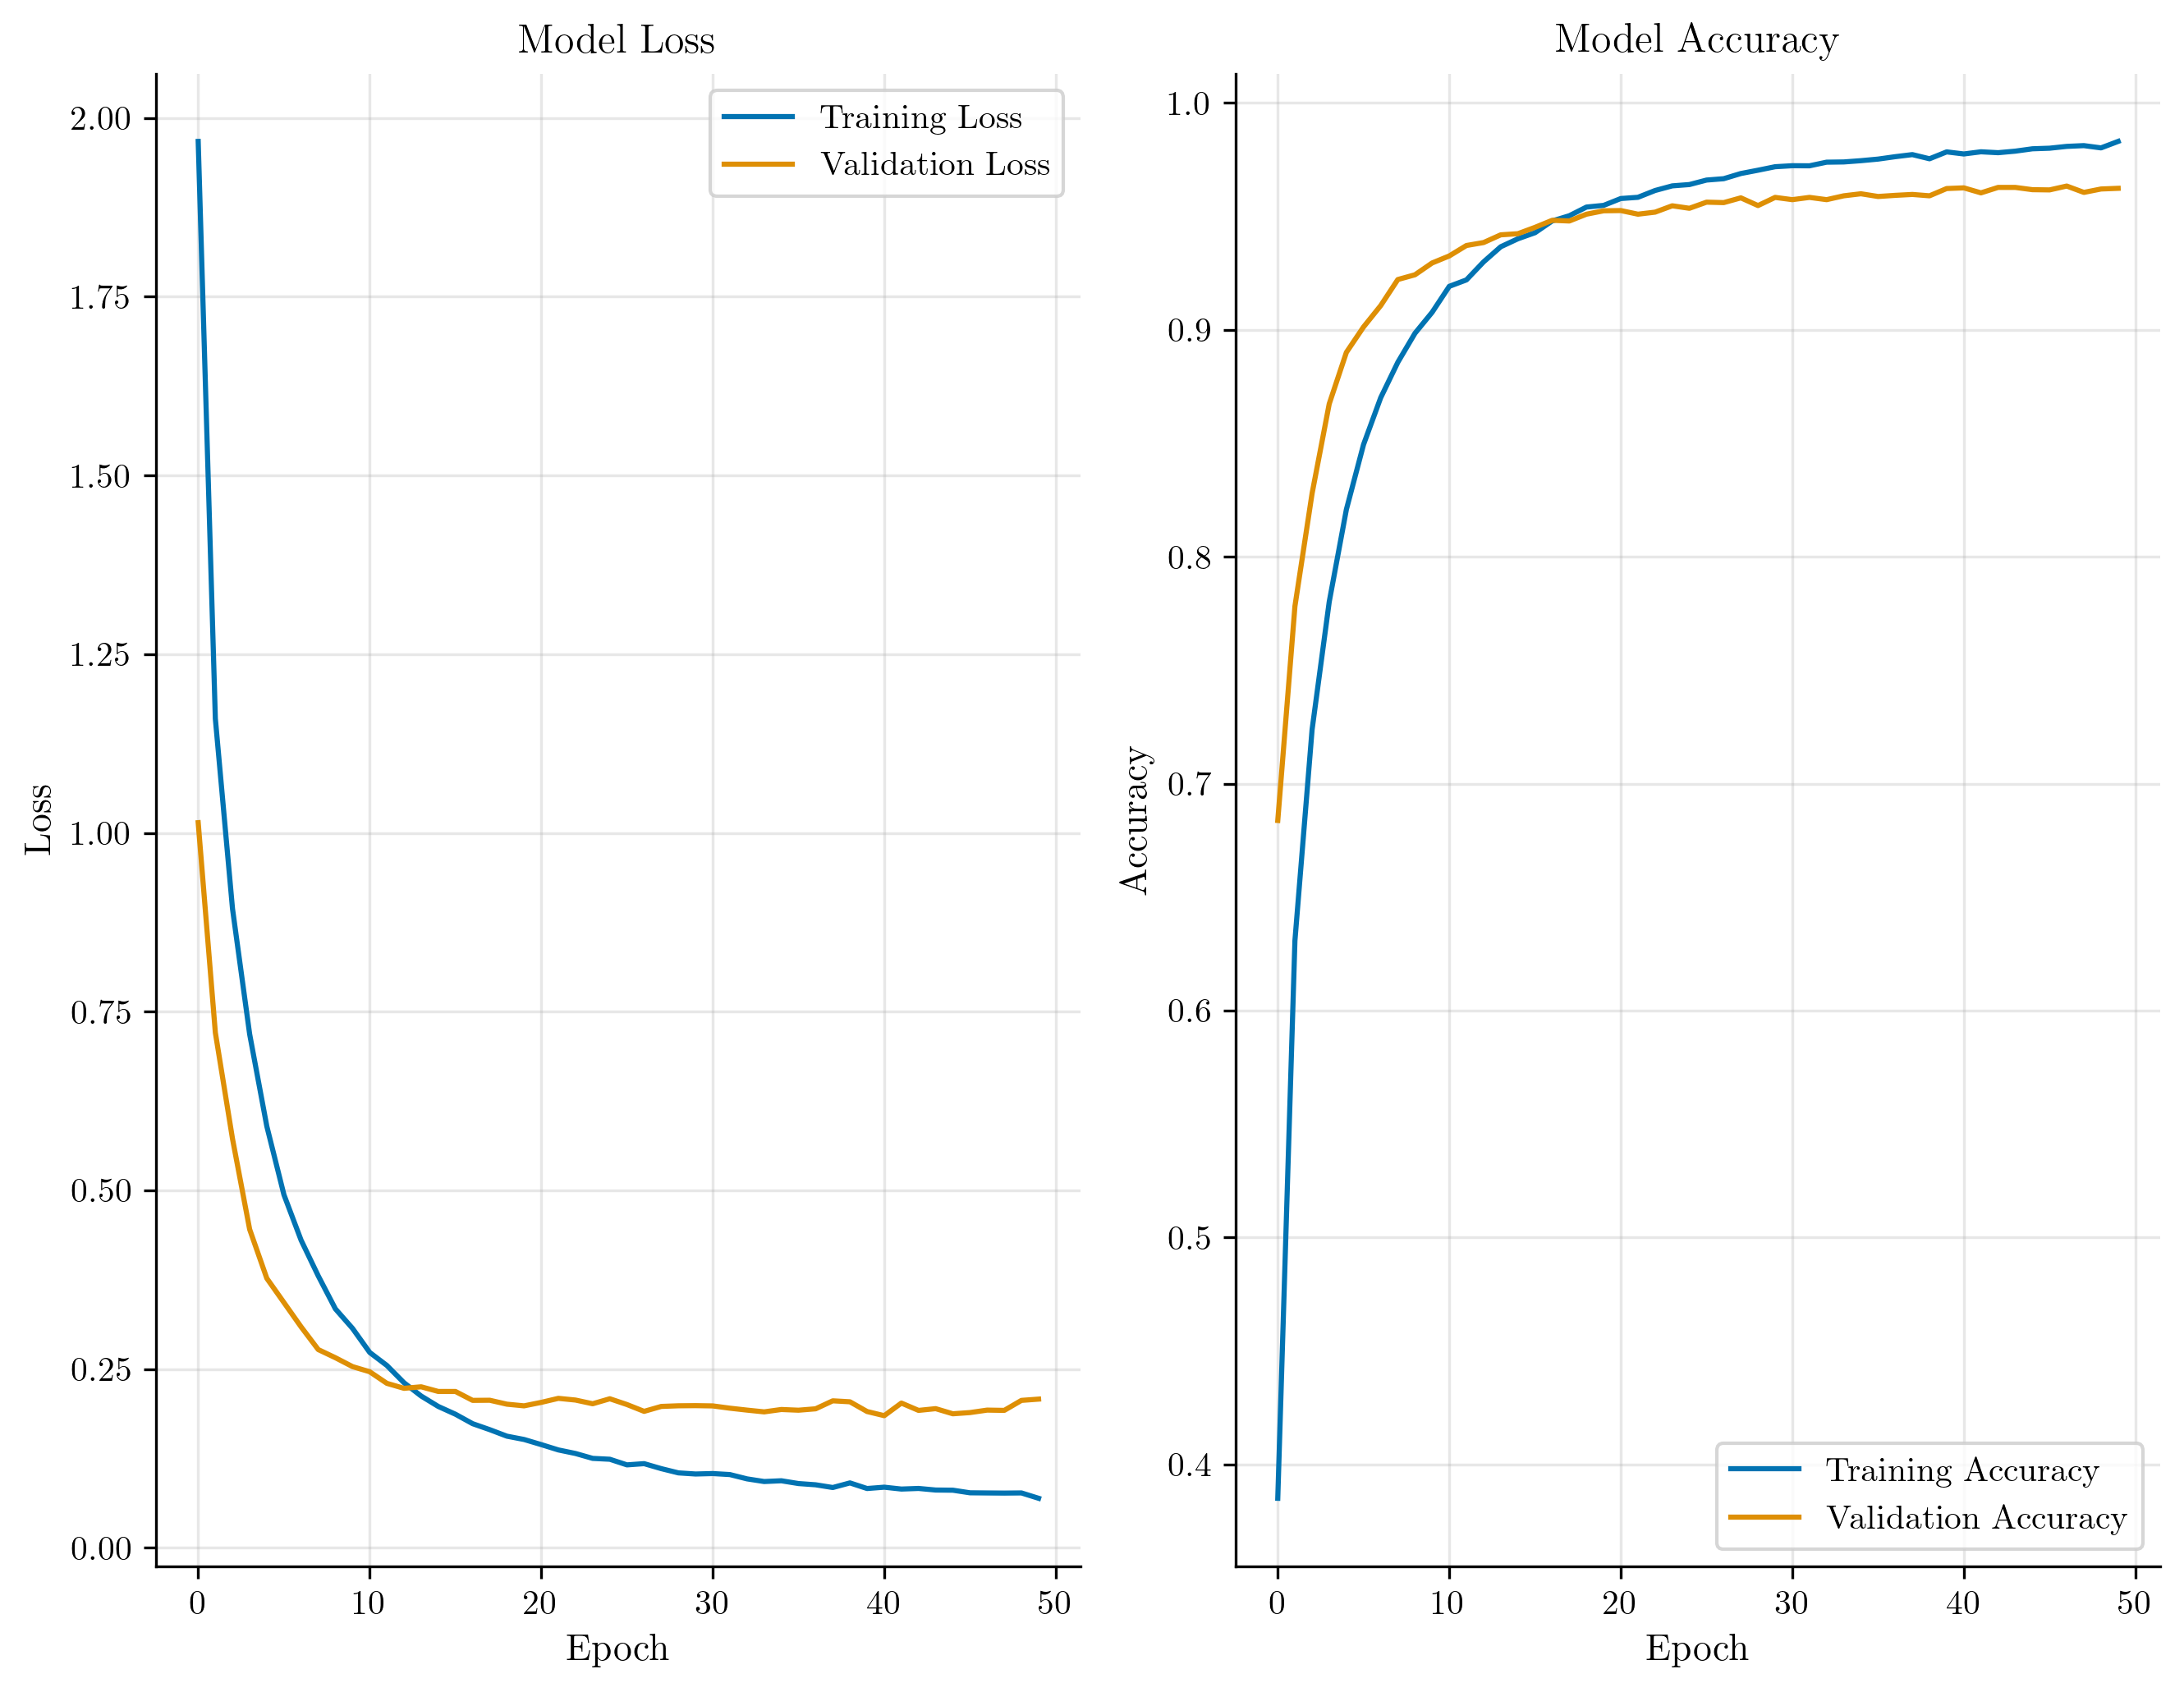

In [6]:
# Get best model from optimization
model = optimizer.best_model

# Plot training history
fig = plot_training_history(model.history)
fig.savefig("../report/images/training_history.pdf", bbox_inches='tight', dpi=300)

## Evaluate Model

Let's evaluate the model's performance on the test set.


Test accuracy: 0.9484

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       110
           1       0.98      0.98      0.98       248
           2       0.96      0.97      0.97       360
           3       0.95      0.97      0.96       436
           4       0.96      0.97      0.96       507
           5       0.94      0.95      0.95       615
           6       0.95      0.94      0.95       659
           7       0.95      0.96      0.96       816
           8       0.95      0.96      0.95       919
           9       0.95      0.94      0.95       994
          10       0.95      0.94      0.94       863
          11       0.94      0.94      0.94       785
          12       0.94      0.94      0.94       688
          13       0.95      0.93      0.94       576
          14       0.91      0.95      0.93       439
          15       0.96      0.94      0.95       395
          16       0.94      0.95 

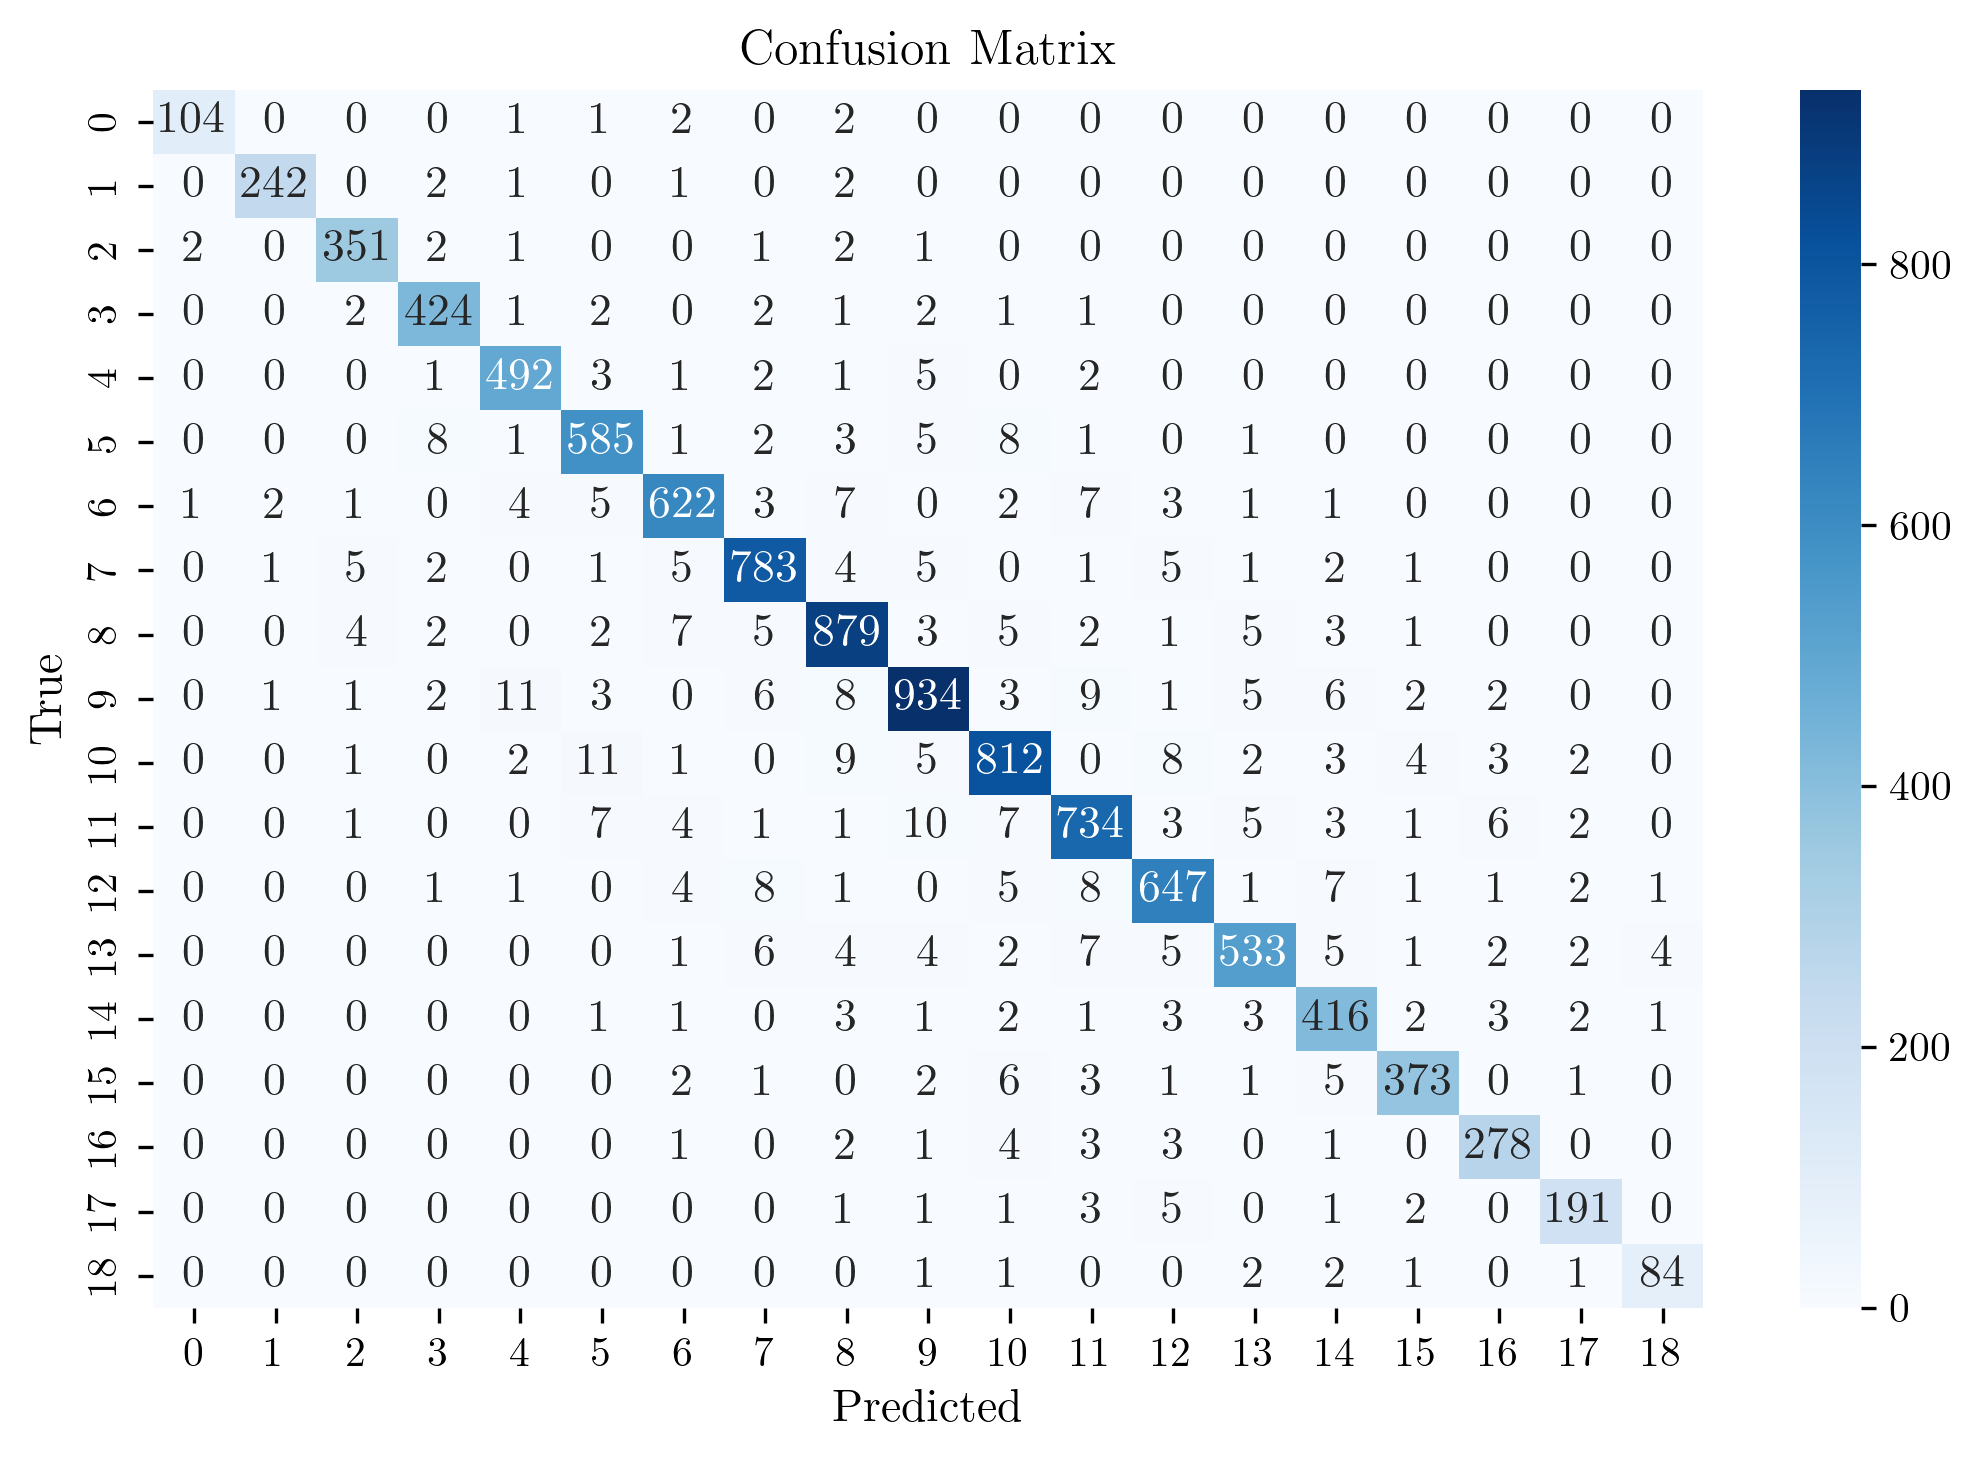

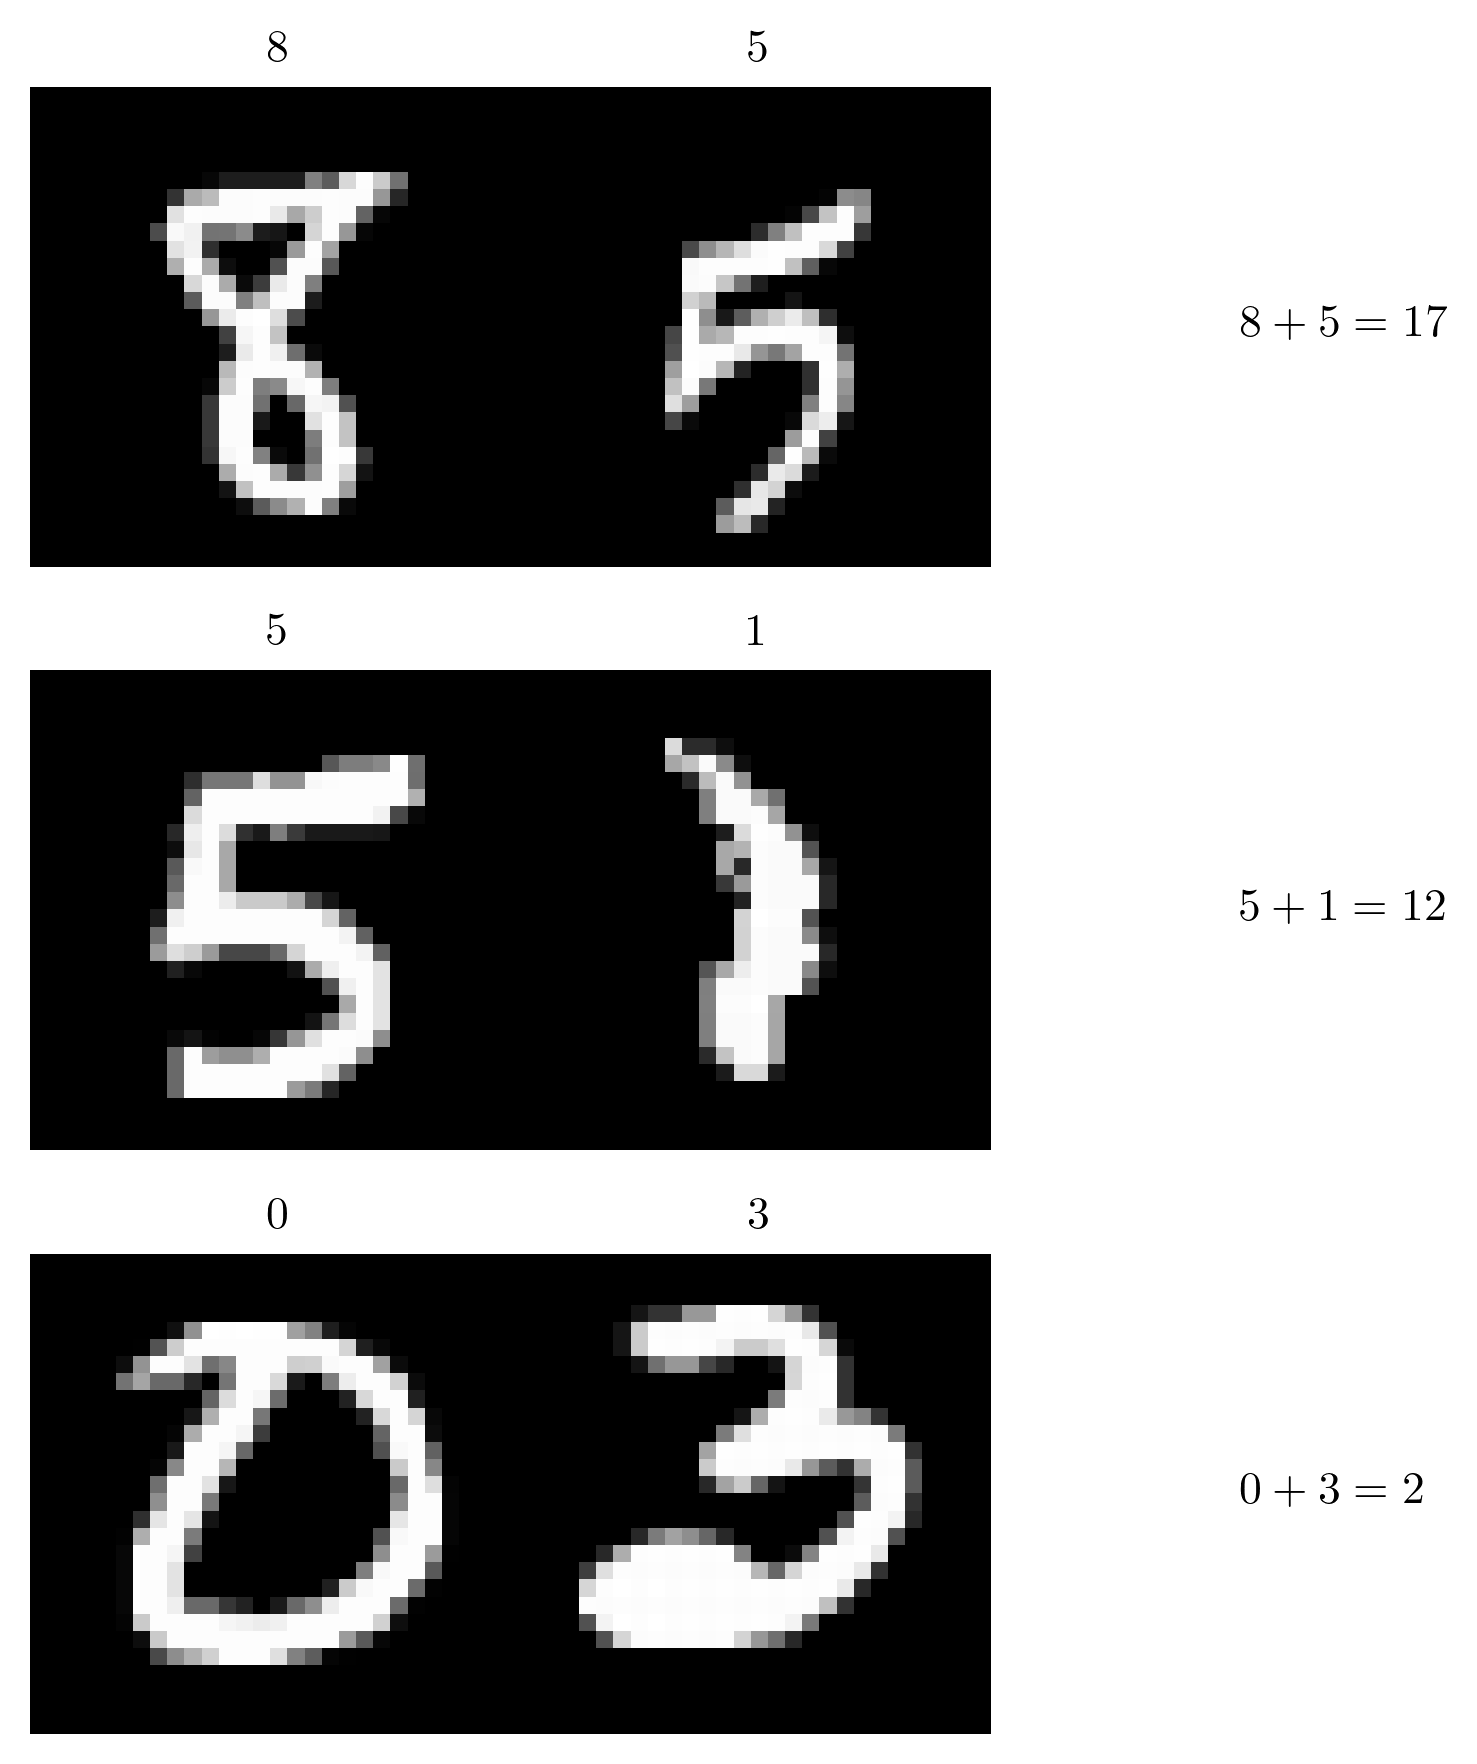

In [16]:
set_publication_style()
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}")

# Generate predictions
y_pred = model.predict(data['test'][0])
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Plot confusion matrix
fig = plot_confusion_matrix(data['test'][1], y_pred_classes, verbose=True)
fig.savefig("../report/images/confusion_matrix.pdf", bbox_inches='tight', dpi=300)

# Visualize incorrect predictions
fig = visualize_incorrect_predictions(
    data['test'][0],
    y_pred_classes,
    data['test'][1],
    data['test'][2]
)
fig.savefig("../report/images/incorrect_predictions.pdf", bbox_inches='tight', dpi=300)

## Save Best Model and Results

Save the best model weights and hyperparameters for reproducibility.

In [8]:
import os
import json

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Save model weights
model.save_weights('models/best_model_weights.weights.h5')

# Save results
results = {
    'best_hyperparameters': best_params,
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss)
}

with open('results/optimization_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Model and results saved successfully!")

Model and results saved successfully!
